# GANomaly: Semi-Supervised Anomaly Detection via Adversarial Training (Method 1 - Original GANomaly)

This notebook is based on the original GANomaly architecture proposed by Akcay et al, in 2018 (https://arxiv.org/abs/1805.06725). The model employs DCGAN architecutre (https://arxiv.org/abs/1511.06434) to create a new anomaly detection model using encoder-decoder-encoder sub-networks that generates high-dimensional image space. The model is trained solely on normal data (in our case undamaged car images), and it attemps to map the input image to a representative latent space, which is then used to reconstruct the generated output image. To map the generated image back to its latent representation, additional encoder network is used. The distance between the input image and the generated image, as well as their latent representations, are minimised during training.

<img src="../GANomaly.png" width="800" height="400">
- <i>Figure A. GANomaly model architechture with Encoder Decoder and Encoder network and the discriminator. </i>
    

The original architecture was built using a PyTorch library which is publicly available in a GitHub repository (https://github.com/samet-akcay/ganomaly). To gain a deeper familiarity with the model and more leeway for customization, we programmed the model architecture from scratch using TensorFlow and Keras libraries.

In [1]:
import py3nvml
import tensorflow as tf
import tensorflow_addons as tfa
py3nvml.grab_gpus(1, gpu_select=[0, 1, 2, 3], gpu_fraction=0.99)
physical_devices = tf.config.list_physical_devices("GPU")

In [2]:
from platform import python_version
print(python_version())
print(tf. __version__) 

3.8.10
2.8.0


## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import random
import math
import os.path
from os import path
import time
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython import display
from scipy.ndimage import gaussian_filter1d

## Options

In [4]:
class Option:
    def __init__(self):
        self.seed = 123
        self.image_shape = [256, 256, 3] # input shape
        self.batch_size = 64 #input batch szie
        self.shuffle_buffer_size = 50 * self.batch_size  # buffer_size: representing the maximum number elements that will be buffered when prefetching
        self.ckpt_dir = "./GANomaly_original_ckpt" # checkponit directory
        self.latent_dim = 100 # latent dims
        self.num_channels = 3 # input channels
        self.filters = 64 # number of generator's and discriminator's filters
        self.lr_d = 2e-4 # discriminator learning rate
        self.lr_g = 2e-4 # generator learning rate
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5 # beta_1 momentum term for Adam optmizer
        self.beta2 = 0.999 # beta_2 momentum term for Adam optmizer
            
opt = Option()

## Load Data

In [5]:
# function to load list from an .npy file
def loadList(filename):
    arr=np.load(filename)
    return arr.tolist()

In [6]:
# saveList(train_undamaged_non_corrupt_clean,'data/train_undamaged_non_corrupt_clean.npy')
train_undamaged = loadList('/data/elnaram/nugen_npy/img_files_toyota_undamaged_3up_non_corrupt.npy')
test_damaged = loadList('/data/elnaram/nugen_npy/img_files_toyota_damaged_3up_non_corrupt.npy')

In [7]:
len(train_undamaged), len(test_damaged)

(6161, 10227)

In [8]:
validation_damaged = random.sample(test_damaged, 1000)
test_damaged = random.sample(test_damaged, 9227)

len(validation_damaged), len(test_damaged)

(1000, 9227)

## Create `Dataset` objects

In [9]:
# Adapted from https://www.tensorflow.org/tutorials/load_data/images
IMAGE_SIZE = [256, 256]

def load_img(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=opt.num_channels)
    img = tf.image.resize(img, [256, 256])
    # img = tf.cast(img, dtype=tf.float32)

    return img

# Adapted from https://stackoverflow.com/questions/48643288/resize-image-preserving-aspect-ratio-in-tensorflow
# Resize image preserving aspect ratio in Tensorflow
def resize_image_keep_aspect(img, lo_dim=256):
    # Take width/height
    initial_width = tf.shape(img)[0]
    initial_height = tf.shape(img)[1]
    # Take the greater value, and use it for the ratio
    min_ = tf.minimum(initial_width, initial_height)
    ratio = tf.cast(min_, dtype=tf.float32) / tf.constant(lo_dim, dtype=tf.float32)
    # Asign new width and height
    new_width = tf.cast((tf.cast(initial_width, dtype=tf.float32) / ratio), dtype=tf.int32)
    new_height = tf.cast((tf.cast(initial_height, dtype=tf.float32) / ratio), dtype=tf.int32)

    return tf.image.resize(img, [new_width, new_height])

# random crop
def random_crop(img):
    img = tf.image.random_crop(img, size=[*opt.image_shape])
    return img

def normalize_img(img):
    return (tf.cast(img, tf.float32) / 127.5) - 1.0

def random_jitter(img):
    img = resize_image_keep_aspect(img, lo_dim=286)
    img = random_crop(img)
    return img

def flip(img):
    return tf.image.flip_left_right(img)

    
def load_train_dataset(filenames):
    ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.concatenate(ds.map(random_jitter, num_parallel_calls=tf.data.AUTOTUNE).shuffle(opt.shuffle_buffer_size))
    ds = ds.concatenate(ds.map(flip, num_parallel_calls=tf.data.AUTOTUNE).shuffle(opt.shuffle_buffer_size))
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(opt.shuffle_buffer_size)
    # ds = ds.cache('/data/elnaram/tfcache_train_GANomaly')
    # ds = ds.shuffle(opt.shuffle_buffer_size)
    ds = ds.batch(opt.batch_size, drop_remainder=True) 
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

def load_val_dataset(filenames):
    ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(resize_image_keep_aspect, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(400)
    ds = ds.batch(8, drop_remainder=True) 
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

def load_test_dataset(filenames):
    ds = tf.data.Dataset.from_tensor_slices(filenames)
    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(resize_image_keep_aspect, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(opt.batch_size, drop_remainder=False) 
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return ds

In [10]:
train_dataset = load_train_dataset(train_undamaged)
train_dataset, len(train_dataset)

2023-01-09 06:46:15.762327: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 06:46:18.086823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30987 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


(<PrefetchDataset element_spec=TensorSpec(shape=(64, 256, 256, 3), dtype=tf.float32, name=None)>,
 385)

In [11]:
val_dataset = load_val_dataset(validation_damaged)
val_dataset, len(val_dataset)

(<PrefetchDataset element_spec=TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None)>,
 125)

In [12]:
test_dataset = load_test_dataset(test_damaged)
test_dataset, len(test_dataset)

(<PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>,
 145)

## Visualize input data

In [13]:
def view_image(ds, rows=1):
    image = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()

    fig = plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        ax = fig.add_subplot(rows, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i] / 2 + .5)

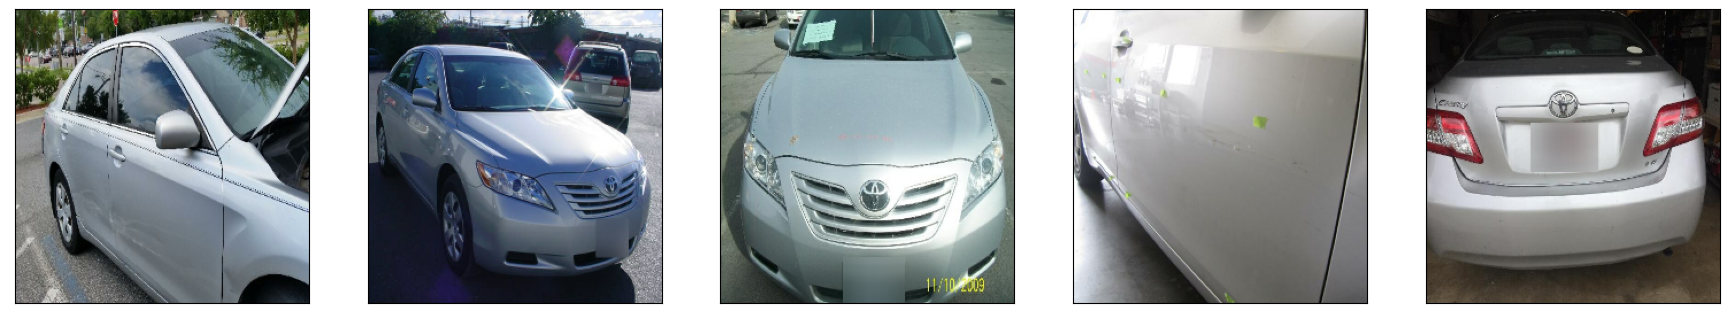

In [14]:
view_image(train_dataset)

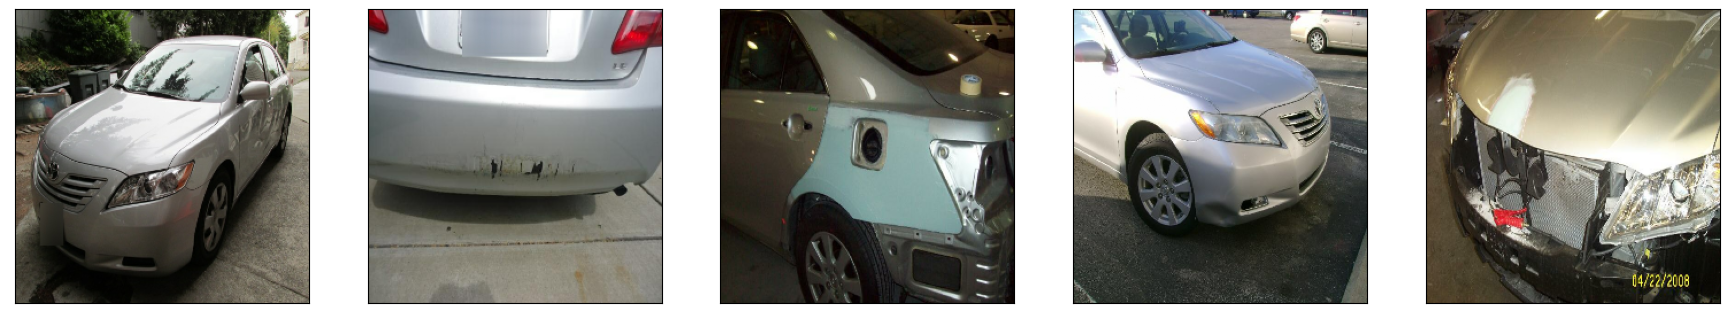

In [15]:
view_image(val_dataset)

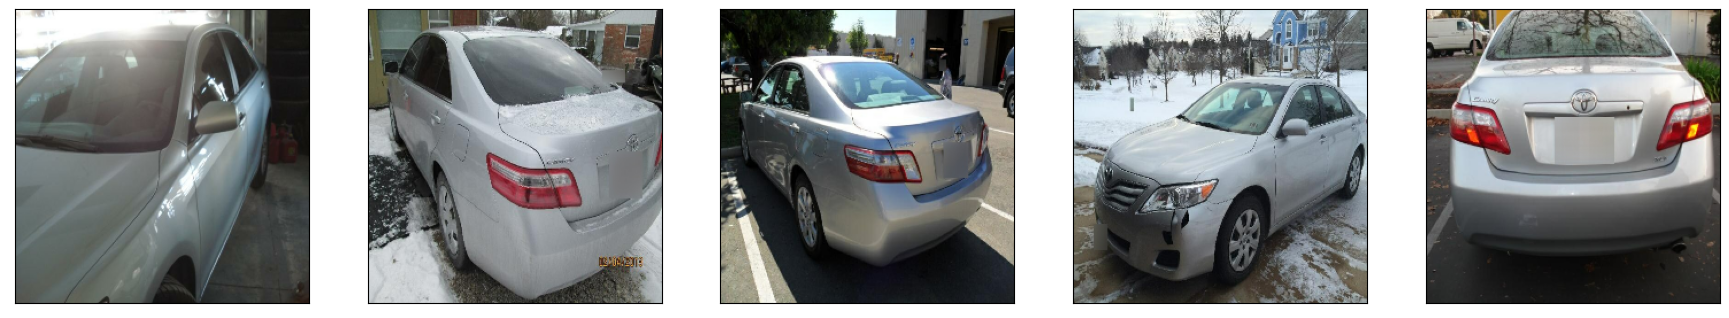

In [16]:
view_image(test_dataset)

## Models

### Encoder model

Input Image ==>> Encoder(Input Image) ==>> Feature Vector

In [17]:
def downsample(filters, strides=(2,2), padding='same', use_bn=True, use_act=True, act_type='lrelu', use_bias=False, encdec=None):
    kernel_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)
    
    result = tf.keras.Sequential(name=encdec)
    result.add(
        tf.keras.layers.Conv2D(filters, 
                               (4,4), 
                               strides=strides, 
                               padding=padding,
                               kernel_initializer=kernel_init, 
                               use_bias=use_bias))

    if use_bn:
        result.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1, name=encdec+'_BatchNorm_{}'.format(int(filters))))
        
    if use_act:
        if act_type=='sigmoid':
            result.add(tf.keras.layers.Activation(tf.sigmoid, name=encdec+'_Sigmoid_{}'.format(int(filters))))
        else:
            result.add(tf.keras.layers.LeakyReLU(alpha=0.2, name=encdec+'_LeakyReLU_{}'.format(int(filters))))
    return result

In [18]:
def upsample(filters, strides=(2,2), padding='same', use_bn=True, use_act=True, act_type='relu', use_bias=False, encdec=None):
    kernel_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

    result = tf.keras.Sequential(name=encdec)
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, 
                                        (4,4), 
                                        strides=strides, 
                                        padding=padding,
                                        kernel_initializer=kernel_init, 
                                        use_bias=False))

    if use_bn:
        result.add(tf.keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1, name=encdec+'_BatchNorm_{}'.format(int(filters))))
    
    if use_act:
        if act_type=='tanh':
            result.add(tf.keras.layers.Activation(tf.tanh, name=encdec+'_Tanh_{}'.format(int(filters))))
        else:
            result.add(tf.keras.layers.ReLU(name=encdec+'_ReLU_{}'.format(int(filters))))

    return result

In [19]:
# define the Encoder network
def Encoder(opt, 
            input_layer, 
            n=1):
    
    e = downsample(opt.filters, use_bn=False, encdec='Encoder-{}_1'.format(n))(input_layer)  # (batch_size, 128, 128, 64)
    e = downsample(opt.filters*2, encdec='Encoder-{}_2'.format(n))(e)  # (batch_size, 64, 64, 128)
    e = downsample(opt.filters*4, encdec='Encoder-{}_3'.format(n))(e)   # (batch_size, 32, 32, 256)
    e = downsample(opt.filters*8, encdec='Encoder-{}_4'.format(n))(e)   # (batch_size, 16, 16, 512)
    e = downsample(opt.filters*16, encdec='Encoder-{}_5'.format(n))(e)   # (batch_size, 8, 8, 1024)
    e = downsample(opt.filters*32, encdec='Encoder-{}_6'.format(n))(e)   # (batch_size, 4, 4, 2048)
    e = downsample(opt.latent_dim, strides=(1,1), padding='valid', use_bn=False, use_act=False, encdec='Encoder-{}_7'.format(n))(e)   # (batch_size, 1, 1, 100)

    return e

### Decoder Model
Feature Vector ==>> Decoder(Feature Vector) ==>> Generated Image

In [20]:
# define the Encoder network
def Decoder(opt, 
            input_layer
           ):
    
    d = upsample(opt.filters*32, strides=(1, 1), padding='valid', encdec='Decoder_1')(input_layer) # (batch_size, 4, 4, 2048)
    d = upsample(opt.filters*16, encdec='Decoder_2')(d)   # (batch_size, 8, 8, 1024)
    d = upsample(opt.filters*8, encdec='Decoder_3')(d)   # (batch_size, 16, 16, 512)
    d = upsample(opt.filters*4, encdec='Decoder_4')(d)   # (batch_size, 32, 32, 256)
    d = upsample(opt.filters*2, encdec='Decoder_5')(d)   # (batch_size, 64, 64, 128)
    d = upsample(opt.filters, encdec='Decoder_6')(d)   # (batch_size, 128, 128, 64)
    d = upsample(opt.num_channels, use_bn=False, act_type='tanh', encdec='Decoder_7')(d)   # (batch_size, 256, 256, 3)
        
    return d

### Generator

In [21]:
def Generator(opt):
    x = tf.keras.layers.Input(shape=opt.image_shape, name='input_image')
    
    # Generator Encoder(1) - Input(X) ==>> G_Encode(X) ==>> Latent_space(Z)
    z = Encoder(opt, x)
    # Generator Decoder - Latent_space(Z) ==>> G_Decoder(Z) ==>> Fake Image(X_hat)
    x_hat = Decoder(opt, z)
    # # Generator Encoder(1) - Fake Image(X_hat) ==>> G_Encoder(X_hat) ==>> Latent_space(Z_o)
    z_o = Encoder(opt, x_hat, n=2)
    
    return tf.keras.models.Model(inputs=x, outputs=[z, x_hat, z_o], name='Generator')

In [22]:
NetG = Generator(opt)
# # summarize the model
NetG.summary(line_length = 150)

Model: "Generator"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_image (InputLayer)                                          [(None, 256, 256, 3)]                                       0                      
                                                                                                                                                      
 Encoder-1_1 (Sequential)                                          (None, 128, 128, 64)                                        3072                   
                                                                                                                                                      
 Encoder-1_2 (Sequential)                                          (None, 6

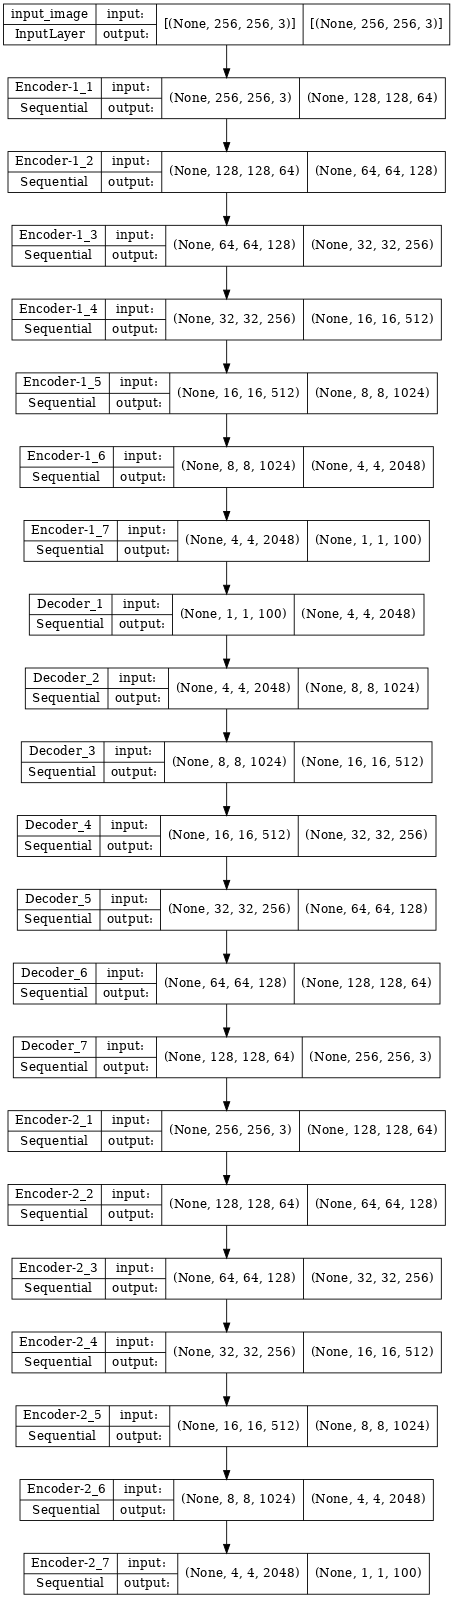

In [23]:
tf.keras.utils.plot_model(NetG, show_shapes=True, dpi=64, to_file='Generator_model.png',)

### Discriminator

In [24]:
def Discriminator(opt):
    
    # Source image input
    x = tf.keras.layers.Input(shape=opt.image_shape, name='input_image')
    
    # Encoder output
    d_1 = downsample(opt.filters, use_bn=False, encdec='Discriminator_encoder_1')(x)  # (batch_size, 128, 128, 64)
    d_2 = downsample(opt.filters*2, encdec='Discriminator_encoder_2')(d_1)  # (batch_size, 64, 64, 128)
    d_3 = downsample(opt.filters*4, encdec='Discriminator_encoder_3')(d_2)   # (batch_size, 32, 32, 256)
    d_4 = downsample(opt.filters*8, encdec='Discriminator_encoder_4')(d_3)   # (batch_size, 16, 16, 512)
    d_5 = downsample(opt.filters*16, encdec='Discriminator_encoder_5')(d_4)   # (batch_size, 8, 8, 1024)
    d_last_feature = downsample(opt.filters*32, encdec='Discriminator_last_feature')(d_5)   # (batch_size, 4, 4, 2048)
    
    d_class = downsample(1, strides=(1,1), padding='valid', act_type='sigmoid', use_bn=False, encdec='Discriminator_class')(d_last_feature)   # (batch_size, 1, 1, 1)
    
    return tf.keras.models.Model(inputs=x, outputs=[d_last_feature, d_class], name='Discriminator')
    

In [25]:
# create the model
NetD = Discriminator(opt)
# summarize the model
NetD.summary(line_length = 150)

Model: "Discriminator"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_image (InputLayer)                                          [(None, 256, 256, 3)]                                       0                      
                                                                                                                                                      
 Discriminator_encoder_1 (Sequential)                              (None, 128, 128, 64)                                        3072                   
                                                                                                                                                      
 Discriminator_encoder_2 (Sequential)                              (Non

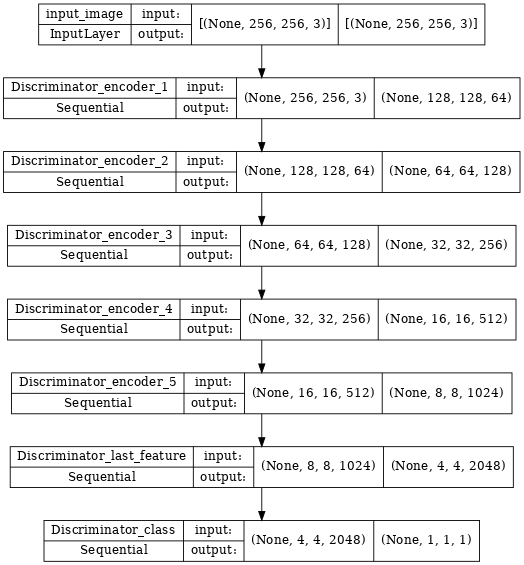

In [26]:
tf.keras.utils.plot_model(NetD, show_shapes=True, show_layer_activations=True, dpi=64, to_file='Discriminator_model.png',)

## Training

### Define Loss functions

<!-- <img src="GANomaly_loss_functions.png" width="500" height="200"> -->

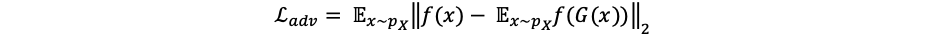
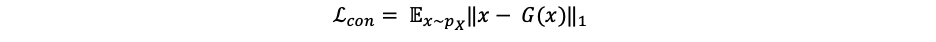
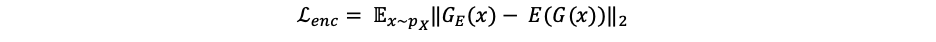
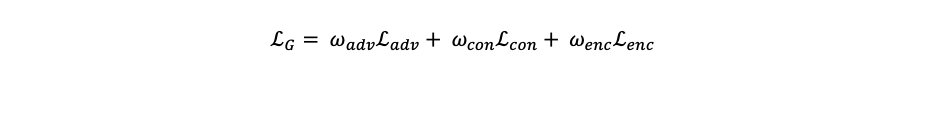

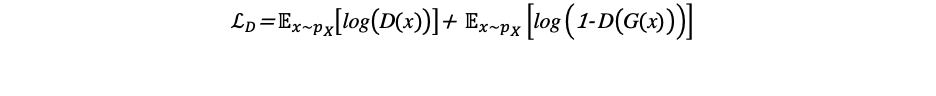

In [27]:
bce_loss = tf.keras.losses.BinaryCrossentropy(name='bce_loss', from_logits=False)

def generator_loss(
    feat_real, feat_fake,
    x, x_hat,
    z, z_o):
    
        ''' Backpropagating through NetG '''
        g_adv = tf.reduce_mean(tf.square(feat_real - feat_fake)) * opt.w_adv
        g_con = tf.reduce_mean(tf.abs(x - x_hat)) * opt.w_con
        g_enc = tf.reduce_mean(tf.square(z - z_o)) * opt.w_enc 

        g_loss = g_adv + g_con + g_enc

        return g_adv, g_con, g_enc, g_loss

def discriminator_loss(pred_real,
                       pred_fake):

    ''' Backpropagating through NetD '''
    
    d_real = bce_loss(tf.ones_like(pred_real), pred_real) 
    d_fake = bce_loss(tf.zeros_like(pred_fake), pred_fake) 

    d_loss = (d_real + d_fake) * 0.5

    return d_real, d_fake, d_loss

### Optimizers

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(opt.lr_g, beta_1=opt.beta1, beta_2=opt.beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(opt.lr_d, beta_1=opt.beta1, beta_2=opt.beta2)

### Checkpoint

In [29]:
checkpoint_dir = opt.ckpt_dir
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=NetG,
                                 discriminator=NetD)

### Generate Images

2023-01-09 06:46:26.098526: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


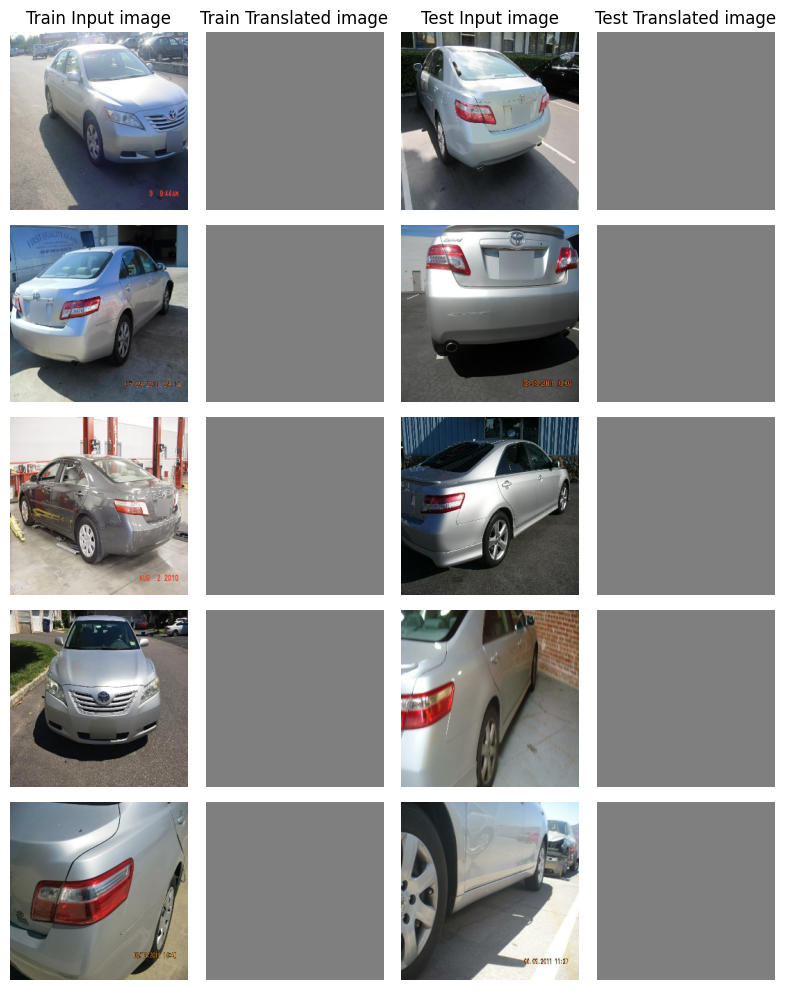

In [30]:
def generate_images(model, train_ds, val_ds, num_img, output):
    fig, ax = plt.subplots(num_img, 4, figsize=(8, 10))
    for i, img_train in enumerate(train_ds.take(num_img)):
        [_, x_hat_train, _] = model(img_train, training=False)
        x_hat_train = (x_hat_train[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        x_train = (img_train[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(x_train)
        ax[i, 1].imshow(x_hat_train)
        ax[0, 0].set_title("Train Input image")
        ax[0, 1].set_title("Train Translated image")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        
    for i, img_test in enumerate(val_ds.take(num_img)):
        [_, x_hat_test, _] = model(img_test, training=False)
        x_hat_test = (x_hat_test[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        x_test = (img_test[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 2].imshow(x_test)
        ax[i, 3].imshow(x_hat_test)
        ax[0, 2].set_title("Test Input image")
        ax[0, 3].set_title("Test Translated image")
        ax[i, 2].axis("off")
        ax[i, 3].axis("off")
    
    fig.savefig(output)
        
    plt.tight_layout()
    plt.show()
    plt.close()

output_file = "sample_generated_img.png"
generate_images(NetG, train_dataset, val_dataset, 5, output_file)

### Train Step Function

In [31]:
@tf.function
def train_step(x):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        z, x_hat, z_o = NetG(x, training=True)
        feat_real, pred_real = NetD(x, training=True)
        feat_fake, pred_fake  = NetD(x_hat, training=True)

        g_adv, g_con, g_enc, g_loss = generator_loss(feat_real, feat_fake, x, x_hat, z, z_o)
        d_real, d_fake, d_loss = discriminator_loss(pred_real,pred_fake)

    generator_gradients = gen_tape.gradient(g_loss, NetG.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    discriminator_gradients = disc_tape.gradient(d_loss, NetD.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    generator_optimizer.apply_gradients(zip(generator_gradients, NetG.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, NetD.trainable_variables))
        
    return g_loss, d_loss, g_adv, g_con, g_enc, d_real, d_fake

### Fit Function

In [34]:
trainlog = pd.DataFrame(columns=['EPOCH', 'Steps', 'G_loss', 'D_loss', 'g_adv', 'g_con', 'g_enc', 'd_X', 'd_X_hat'])

In [35]:
# Adapted from https://www.tensorflow.org/tutorials/generative/pix2pix
def fit(train_ds, val_ds, epochs):
    start = time.time()
    global_step=0
    for epoch in range(epochs):
        start = time.time()

        G_losses = []
        D_losses = []
        
        step=0
        for image_batch in train_ds:
            global_step+=1
            step+=1

            G_loss, D_loss, g_adv, g_con, g_enc, d_x, d_x_hat = train_step(image_batch)
            trainlog.loc[len(trainlog)] = [epoch+1, global_step, G_loss.numpy(), D_loss.numpy(), g_adv.numpy(), g_con.numpy(), g_enc.numpy(), d_x.numpy(), d_x_hat.numpy()]
            
            G_losses.append(G_loss)
            D_losses.append(D_loss)

            print ("\033[1mGlobal Steps\033[0m: {}, \033[1mEpoch Steps\033[0m: {},\
                   \033[91mG_LOSS\033[0m: {:.4f}, \033[91mD_LOSS\033[0m: {:.4f}, \
                   \033[94mg_adv\033[0m: {:.4f}, \033[94mg_con\033[0m: {:.4f}, \033[94mg_enc\033[0m: {:.4f}, \
                   \033[92md_real\033[0m: {:.4f}, \033[92md_fake\033[0m: {:.4f}"
                   .format(global_step, 
                            step, 
                            G_loss.numpy(), 
                            D_loss.numpy(),
                            g_adv.numpy(), 
                            g_con.numpy(),
                            g_enc.numpy(),
                            d_x.numpy(), 
                            d_x_hat.numpy()
                           ),
                   end='', flush=True)
            print('\r', end='')
                
       
        display.clear_output(wait=True)
        print (f"Epoch : {epoch+1}, \t Time : {time.time()-start:.2f} sec/n, \t Gen Loss mean : {np.mean(G_losses):.4f}, std: {np.std(G_losses):.4f}; \t Dis Loss mean : {np.mean(D_losses):.4f}, std: {np.std(D_losses):.4f};")
         # Generate training and validation images
        output_file = f"GANomaly_original_gen_imgs/generated_imgs_{epoch+1}.png"
        generate_images(NetG, train_ds, val_ds, 5, output_file)
        # print("\r", end="")
        
        # plot the losses
        plt.figure(figsize=(10,4))
        plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch+1))
        plt.plot(G_losses,label="G")
        plt.plot(D_losses,label="D")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, linestyle='--')
        ymax = plt.ylim()[1]
        plt.show()
        
        trainlog.plot(x="Steps", y=["D_loss", "G_loss"], figsize=(10, 4), ylim=(0,30))
        plt.title("All Time Loss")
        plt.ylabel("Loss")
        plt.xlabel("Iterations")
        G_loss_smoothed = gaussian_filter1d(trainlog.G_loss, sigma=25)
        plt.plot(trainlog.Steps, G_loss_smoothed)
        plt.grid(True, linestyle='--')
        plt.show()
         
        if (epoch+1) % 300 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            

Epoch : 300, 	 Time : 288.77 sec/n, 	 Gen Loss mean : 4.6738, std: 0.2953; 	 Dis Loss mean : 0.0000, std: 0.0001;


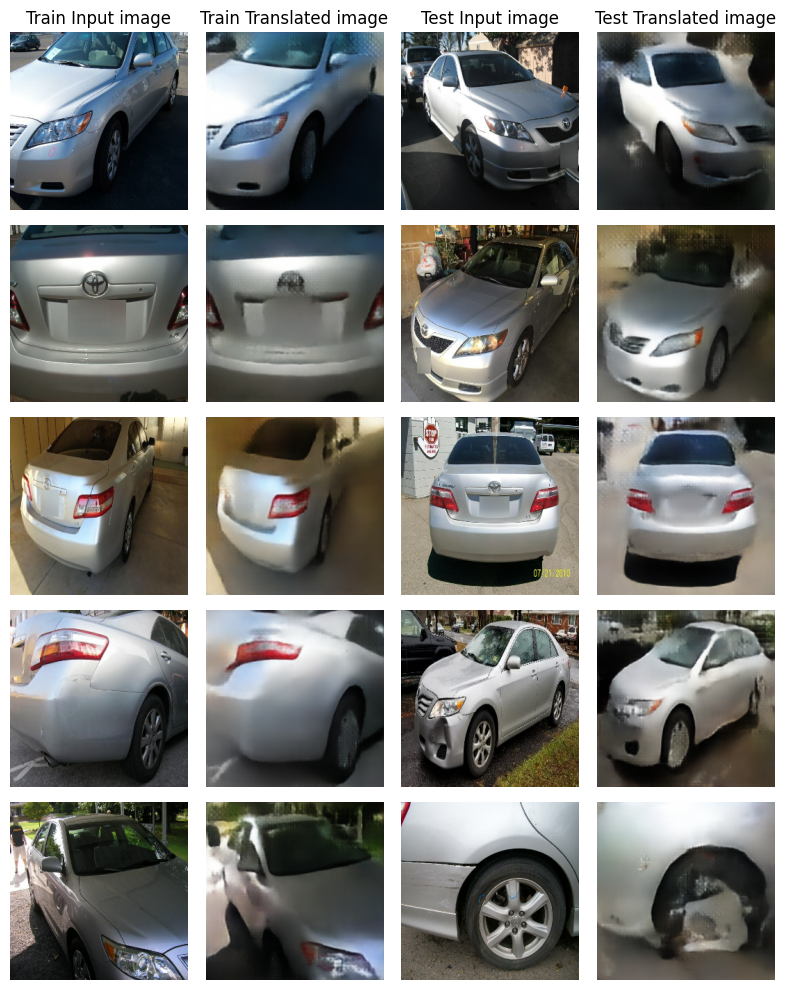

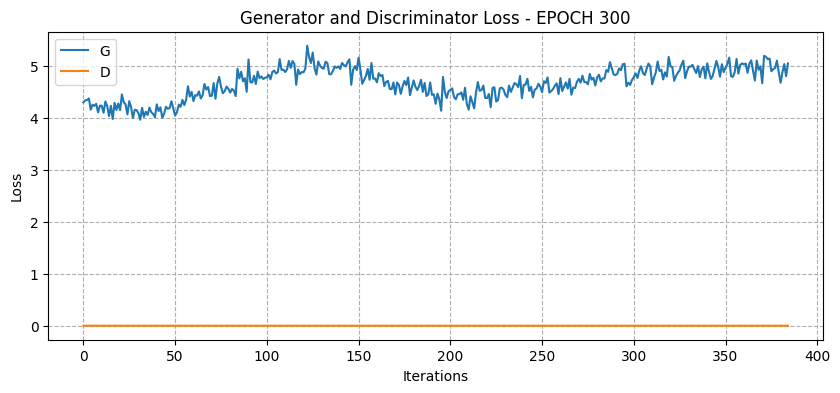

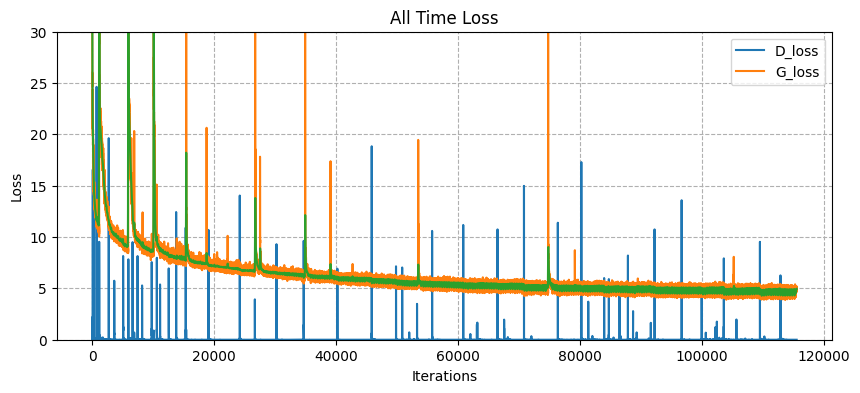

In [36]:
fit(train_dataset, val_dataset, epochs=300)

## Trainlog

In [37]:
trainlog.to_csv('trainlog_GANomaly_original.csv', index=False)

In [32]:
trainlog = pd.read_csv('trainlog_GANomaly_original.csv')

In [33]:
trainlog

EPOCH     Steps     G_loss        D_loss     g_adv      g_con  \
0         1.0       1.0  38.286865  1.035504e+00  0.788989  23.817657   
1         1.0       2.0  78.733704  8.775337e-02  0.793970  23.490746   
2         1.0       3.0  53.744499  2.182127e+00  0.794570  23.687189   
3         1.0       4.0  84.840126  2.415633e-01  0.805156  23.856379   
4         1.0       5.0  93.095222  3.609088e-01  0.797410  23.380081   
...       ...       ...        ...           ...       ...        ...   
115495  300.0  115496.0   4.681660  1.063376e-04  0.120568   4.548221   
115496  300.0  115497.0   4.884412  2.235467e-05  0.136051   4.735699   
115497  300.0  115498.0   5.042799  2.162650e-11  0.171060   4.859378   
115498  300.0  115499.0   4.809262  2.296948e-09  0.153314   4.642951   
115499  300.0  115500.0   5.054355  1.159941e-08  0.157552   4.881909   

            g_enc           d_X       d_X_hat  
0       13.680220  1.224803e+00  8.462054e-01  
1       54.448986  1.755060e-01  7.222736e-07  
2       29.262739  3.828053e-05  4.364215e+00  
3       60.178589  4.831266e-01  4.727253e-17  
4       68.917732  7.218176e-01  1.856654e-12  
...           ...           ...           ...  
115495   0.012871  2.126751e-04  2.712736e-19  
115496   0.012662  4.470934e-05  4.306510e-19  
115497   0.012361  4.325300e-11  1.018366e-19  
115498   0.012997  4.593895e-09  1.165510e-18  
115499   0.014894  2.319882e-08  2.765749e-19  

[115500 rows x 9 columns]

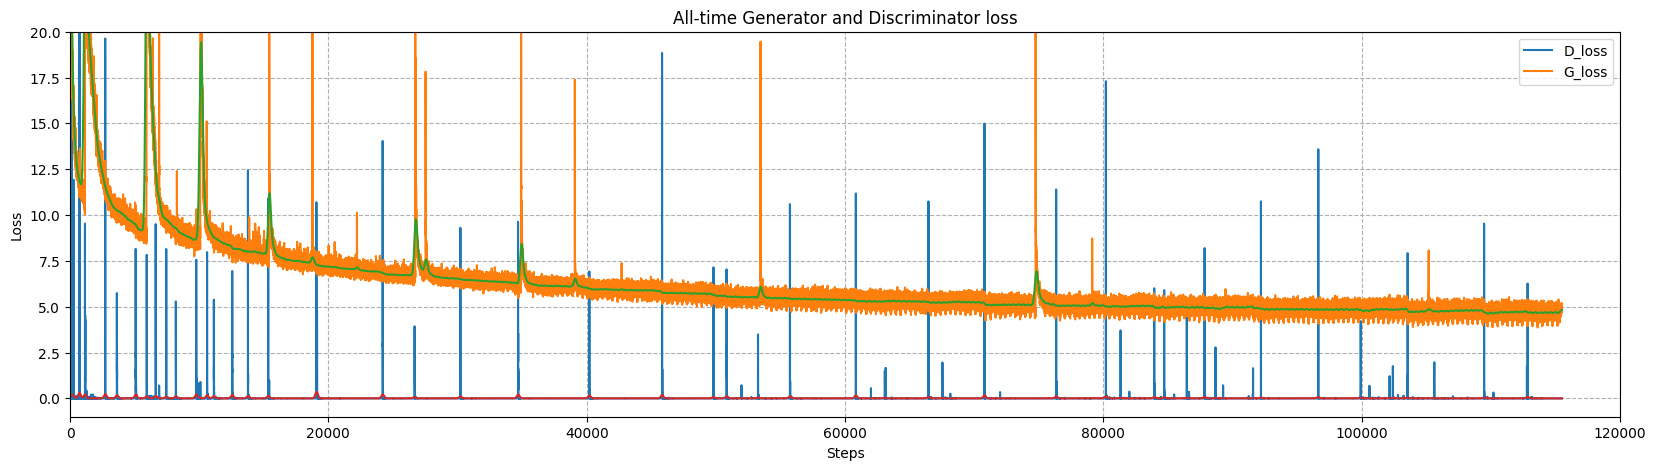

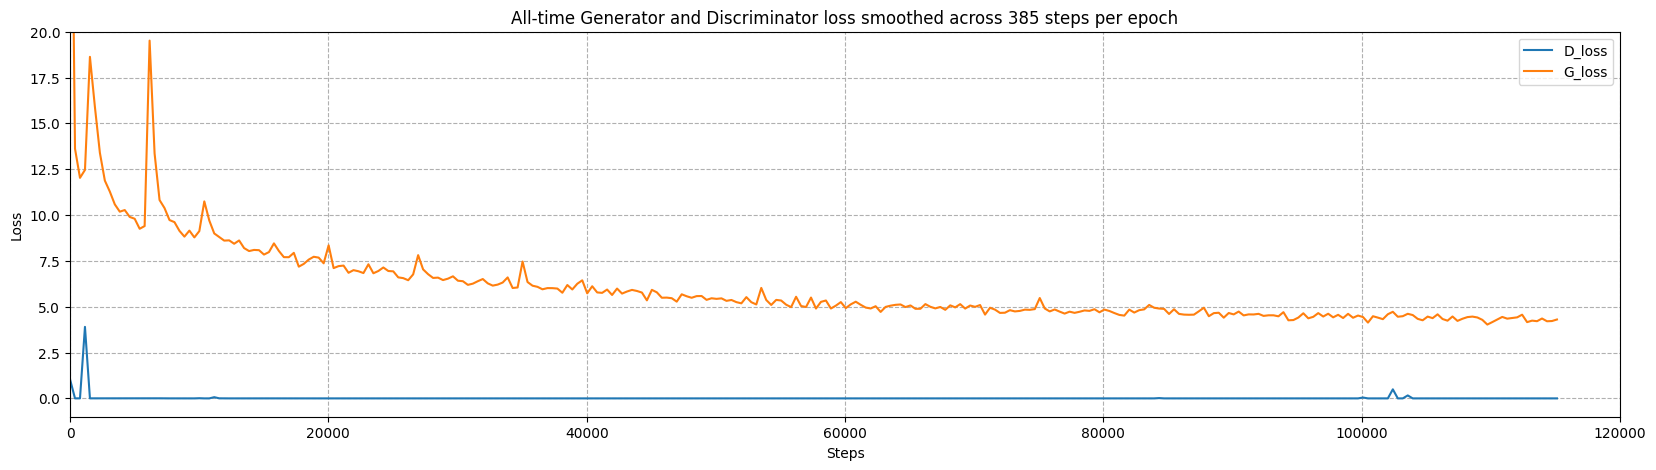

In [34]:
# Plot Discriminator and Generator Losses
trainlog.plot(x="Steps", y=["D_loss", "G_loss"], figsize=(20, 5), ylim=(-1,20))
G_loss_smoothed = gaussian_filter1d(trainlog.G_loss, sigma=100)
D_loss_smoothed = gaussian_filter1d(trainlog.D_loss, sigma=100)
plt.plot(trainlog.Steps, G_loss_smoothed)
plt.plot(trainlog.Steps, D_loss_smoothed)
plt.grid(True, linestyle='--')
plt.ylabel("Loss")
plt.xlim(0, 120000)
plt.title("All-time Generator and Discriminator loss")
plt.show()

plt.figure(figsize=(20,5))
Disc_Loss = trainlog.D_loss[::385]
Gen_Loss = trainlog.G_loss[::385]
steps = trainlog.Steps[::385]
plt.plot(steps, Disc_Loss, label='D_loss')
plt.plot(steps, Gen_Loss, label='G_loss')
plt.grid(True, linestyle='--')
plt.legend(loc="upper right")
plt.ylim(-1, 20)
plt.xlim(0, 120000)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("All-time Generator and Discriminator loss smoothed across 385 steps per epoch")
plt.show()

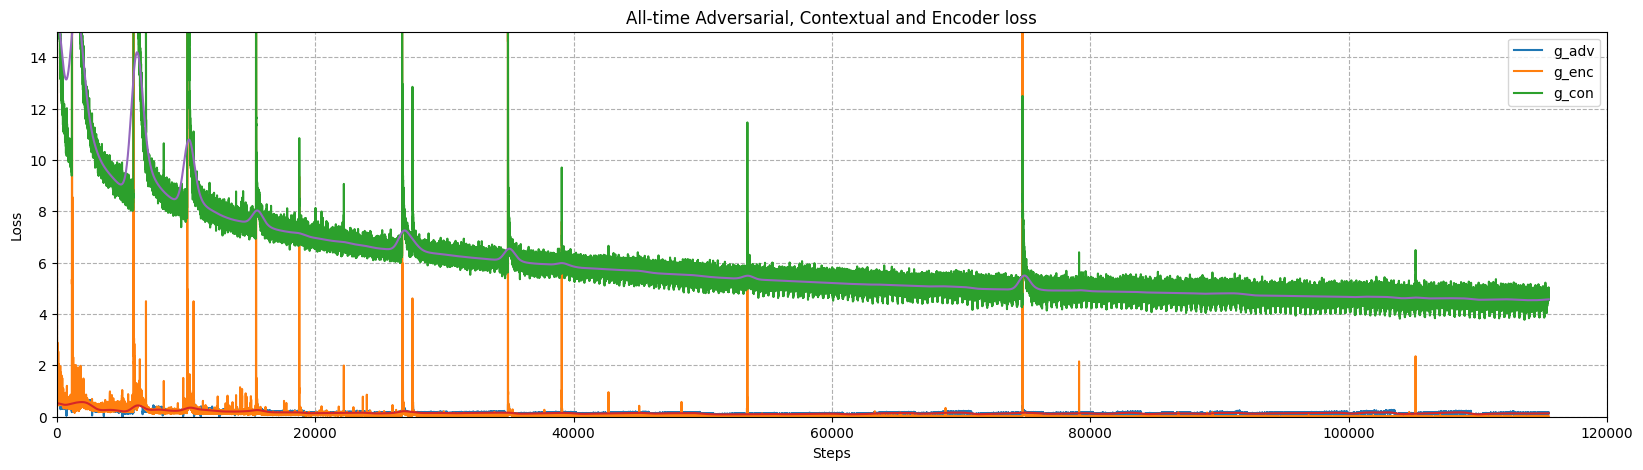

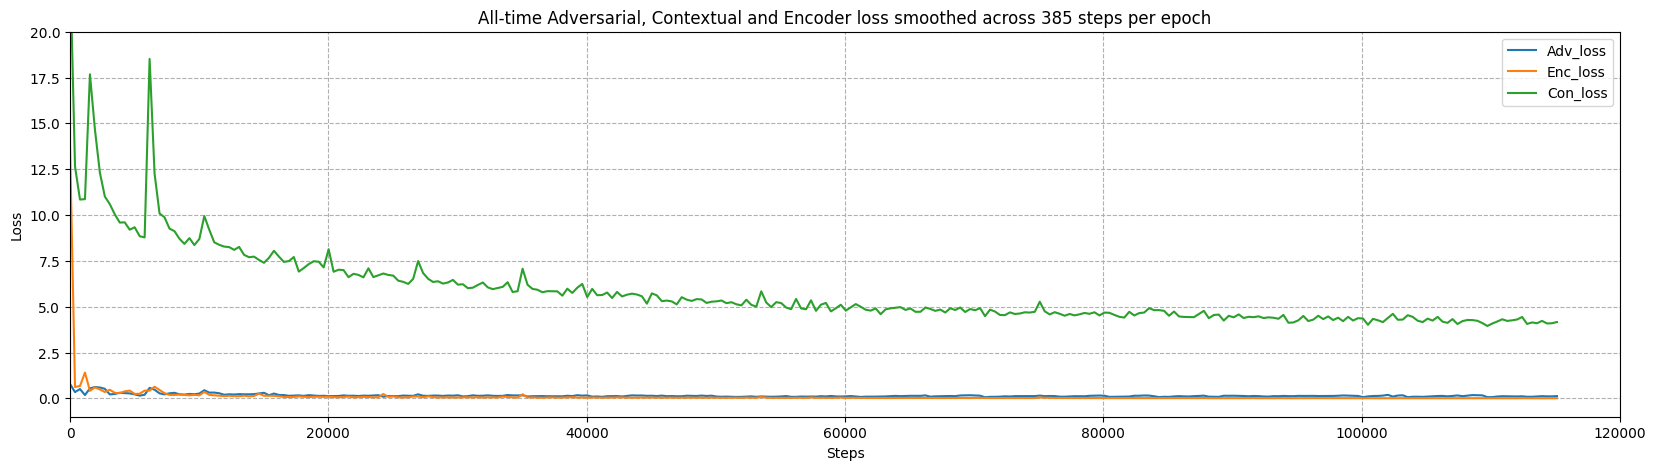

In [35]:
# plot Adversarial, Contextual and Encoder Losses
trainlog.plot(x="Steps", y=["g_adv", "g_enc", "g_con"], figsize=(20, 5), ylim=(0,15))
g_adv_smoothed = gaussian_filter1d(trainlog.g_adv, sigma=385)
g_con_smoothed = gaussian_filter1d(trainlog.g_con, sigma=385)
plt.plot(trainlog.Steps, g_adv_smoothed)
plt.plot(trainlog.Steps, g_con_smoothed)
plt.grid(True, linestyle='--')
plt.ylabel("Loss")
plt.xlim(0, 120000)
plt.title("All-time Adversarial, Contextual and Encoder loss")
plt.show()

plt.figure(figsize=(20,5))
Adv_loss = trainlog.g_adv[::385]
Enc_loss = trainlog.g_enc[::385]
Con_loss = trainlog.g_con[::385]
steps = trainlog.Steps[::385]
plt.plot(steps, Adv_loss, label='Adv_loss')
plt.plot(steps, Enc_loss, label='Enc_loss')
plt.plot(steps, Con_loss, label='Con_loss')
plt.grid(True, linestyle='--')
plt.legend(loc="upper right")
plt.ylim(-1, 20)
plt.xlim(0, 120000)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("All-time Adversarial, Contextual and Encoder loss smoothed across 385 steps per epoch")
plt.show()

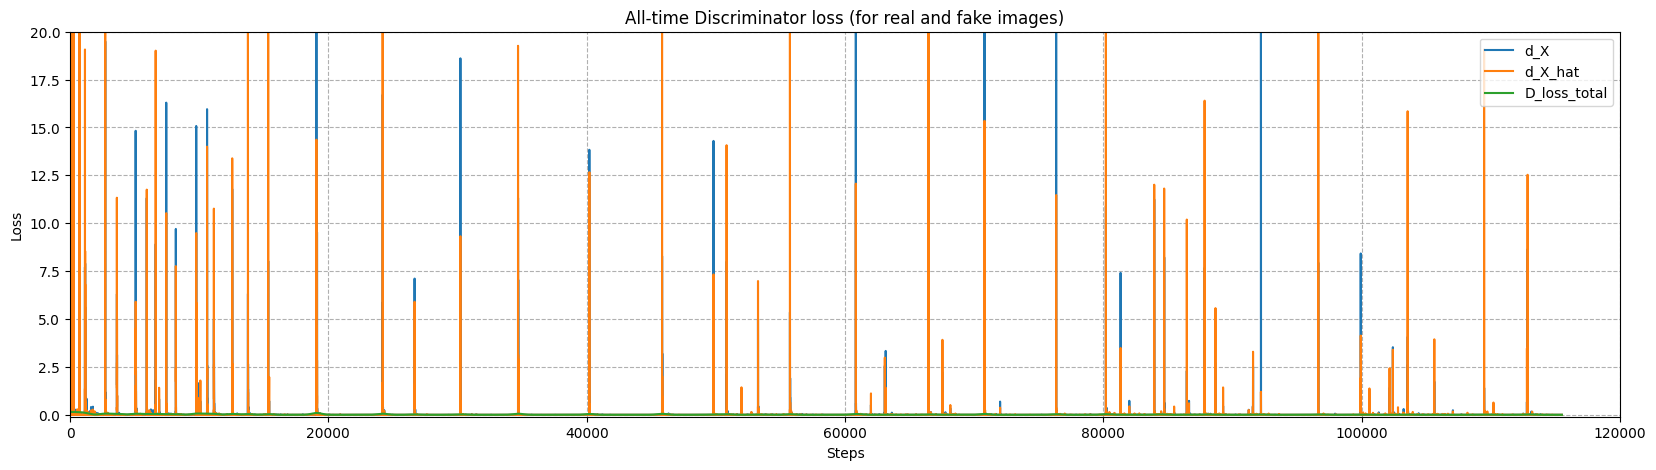

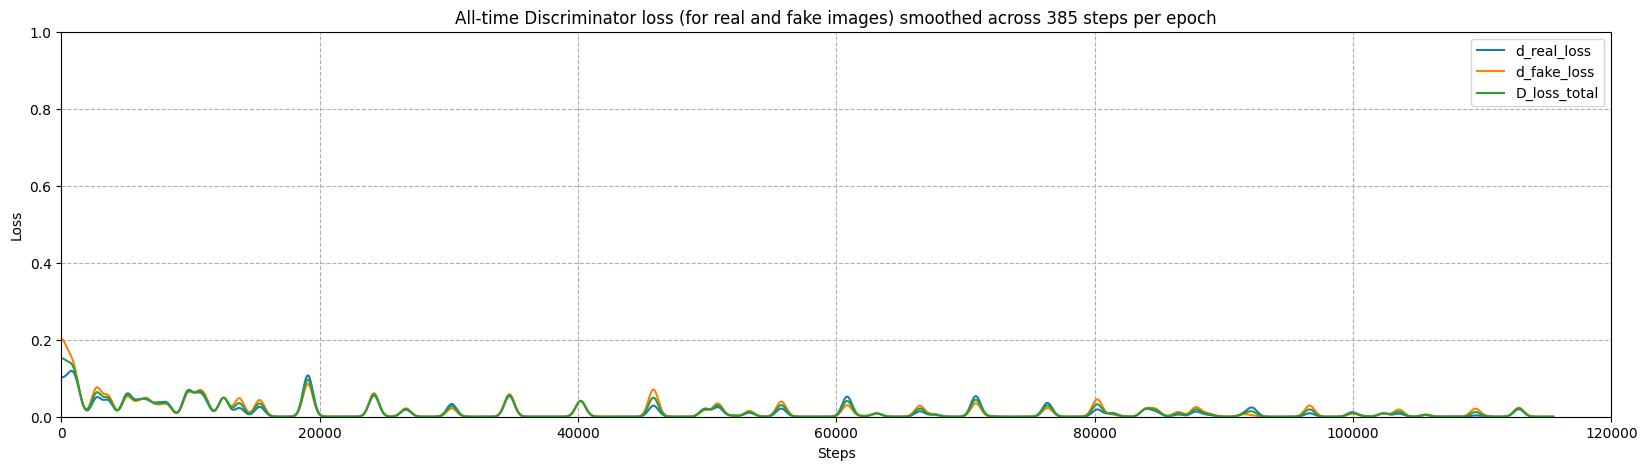

In [36]:
# plot Discriminator Losses
trainlog.plot(x="Steps", y=["d_X", "d_X_hat"], figsize=(20, 5))
D_loss_smoothed = gaussian_filter1d(trainlog.D_loss, sigma=385)
plt.plot(trainlog.Steps, D_loss_smoothed, label='D_loss_total')
plt.grid(True, linestyle='--')
plt.legend(loc="upper right")
plt.ylim(-0.1,20)
plt.xlim(0, 120000)
plt.ylabel("Loss")
plt.title("All-time Discriminator loss (for real and fake images)")
plt.show()


plt.figure(figsize=(20,5))
d_x_smoothed = gaussian_filter1d(trainlog.d_X, sigma=385)
d_x_hat_smoothed = gaussian_filter1d(trainlog.d_X_hat, sigma=385)
D_loss_smoothed = gaussian_filter1d(trainlog.D_loss, sigma=385)
plt.plot(trainlog.Steps, d_x_smoothed, label='d_real_loss')
plt.plot(trainlog.Steps, d_x_hat_smoothed, label='d_fake_loss')
plt.plot(trainlog.Steps, D_loss_smoothed, label='D_loss_total')
plt.legend(loc="upper right")
plt.xlim(0, 120000)
plt.grid(True, linestyle='--')
plt.ylim(0,1)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("All-time Discriminator loss (for real and fake images) smoothed across 385 steps per epoch")
plt.show()

## FID Score

In [36]:
ls {checkpoint_dir}

checkpoint  ckpt-1.data-00000-of-00001  ckpt-1.index


In [37]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [38]:
# The following FID calculation code has been adapted from Machine learning mastery
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# Inceptionv3 model for FID calculation
from tensorflow.keras.applications.inception_v3 import InceptionV3
INCEPTION_SHAPE = (299, 299, 3)

inception = InceptionV3(include_top=False, pooling='avg', input_shape=INCEPTION_SHAPE)

def scale_images(images, new_shape):
    """
    Scales images into new shape by interpolation since inception model requires that
    :param images: List of images
    :param new_shape: The transformed shape
    :return: Transformed images
    """

    images_list = list()

    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    
    return np.asarray(images_list)


def calculate_fid(model, images1, images2):
    """

    Calculates the FID with the inception last layer activations
    :param model: THe model (eg: inception)
    :param images1: List of images grouo 1
    :param images1: List of images grouo 2
    :return: FID score
    """
    
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Equation for FID score calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)  

    return fid

In [41]:
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
np_config.enable_numpy_behavior()
FID_BATCH_SIZE = 10

from skimage.transform import resize
fid_train_total = []
for i, x in enumerate(train_dataset.take(50)):
    [_, x_hat, _] = NetG(x, training=False)
    x = scale_images(x.astype('float32'), INCEPTION_SHAPE)
    x_hat = scale_images(x_hat.astype('float32'), INCEPTION_SHAPE)
    x = preprocess_input(x)
    x_hat = preprocess_input(x_hat)
    cur_fid_score = calculate_fid(inception, x, x_hat)
    fid_train_total.append(cur_fid_score)
    print(cur_fid_score)

8.18805198875477
10.018683746926003
8.118314750384307
8.147398733287368
9.660250115953135
11.036465126012002
8.93739463059248
8.582851460015393
9.227290103890052
8.969640868994427
10.793412917338344
7.594897342504549
8.599031516295106
8.904499617441221
10.439541917175012
8.126100295848095
8.866991640022436
9.120793316346612
8.013822023592933
9.28115747153411
7.635819748645002
8.896277891252124
9.033048759652722
8.329201195642835
9.532786949906171
9.144243073085487
10.034570341769165
7.437978612905386
8.144360773327943
10.173454855115427
8.254034099979734
11.094140205035083
11.34957338238912
10.472878627865382
8.161863694059504
7.748790401822118
8.897577274624055
7.4806070281610815
10.40854237643569
9.319798391378411
7.502117140176514
9.260429490991942
8.55408077386129
8.95640947384813
7.795908331880999
8.593679941255964
9.417328822773676
9.19344627672029
7.741235239608564
8.175611958277411


In [51]:
print(f'Mean Fid Score for train dataset: {np.mean(fid_train_total):.4f}')
print(f'Standard Deviation Fid Score for train dataset: {np.std(fid_train_total):.4f}')

Mean Fid Score for train dataset: 8.9714
Standard Deviation Fid Score for train dataset: 0.8797


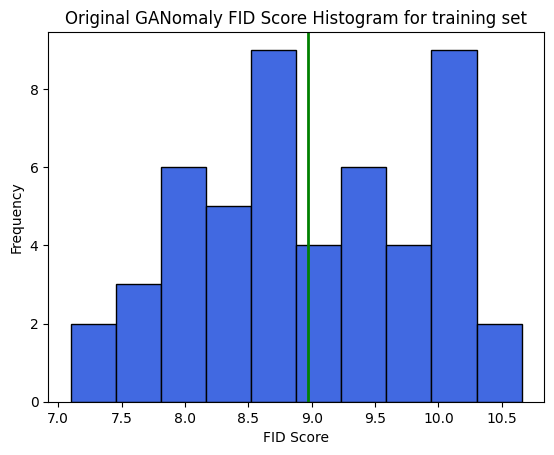

In [92]:
import statistics

plt.hist(fid_train_total, bins=10, color='royalblue', edgecolor='k')

mean = statistics.mean(fid_train_total)
std = statistics.stdev(fid_train_total)

plt.axvline(mean, color='g', lw=2.0)

plt.xlabel("FID Score")
plt.ylabel("Frequency")
plt.title("Original GANomaly FID Score Histogram for training set")
plt.show()

In [39]:
fid_test_total = []
for i, x in enumerate(val_dataset.take(50)):
    [_, x_hat, _] = NetG(x, training=False)
    x = scale_images(x.astype('float32'), INCEPTION_SHAPE)
    x_hat = scale_images(x_hat.astype('float32'), INCEPTION_SHAPE)
    x = preprocess_input(x)
    x_hat = preprocess_input(x_hat)
    cur_fid_score = calculate_fid(inception, x, x_hat)
    fid_test_total.append(cur_fid_score)
    print(cur_fid_score)

AttributeError: 
        'EagerTensor' object has no attribute 'astype'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

In [40]:
print(f'Mean Fid Score for test dataset: {np.mean(fid_test_total):.4f}')
print(f'Standard Deviation Fid Score for test dataset: {np.std(fid_test_total):.4f}')

Mean Fid Score for test dataset: nan
Standard Deviation Fid Score for test dataset: nan


/opt/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


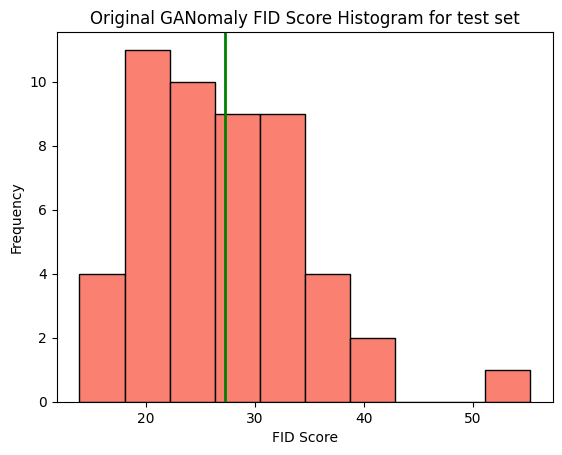

In [94]:
import statistics

plt.hist(fid_test_total, bins=10, color='salmon', edgecolor='k')

mean = statistics.mean(fid_test_total)
std = statistics.stdev(fid_test_total)

plt.axvline(mean, color='g', lw=2.0)

plt.xlabel("FID Score")
plt.ylabel("Frequency")
plt.title("Original GANomaly FID Score Histogram for test set")
plt.show()

## Inference

In [39]:
# Run the trained model on a few examples from the test set
def generate_test_images(model, dataset, num_img):
    fig, ax = plt.subplots(num_img, 2, figsize=(5, num_img * 2 ))
    for i, img in enumerate(dataset.take(num_img)):
        [z, x_hat, z_o] = model(img, training=False)
        x_hat = (x_hat[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        x = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(x)
        ax[i, 1].imshow(x_hat)
        ax[0, 0].set_title("Input image")
        ax[0, 1].set_title("Translated image")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        
    # fig.savefig(output)
        
    plt.tight_layout()
    plt.show()
    plt.close()

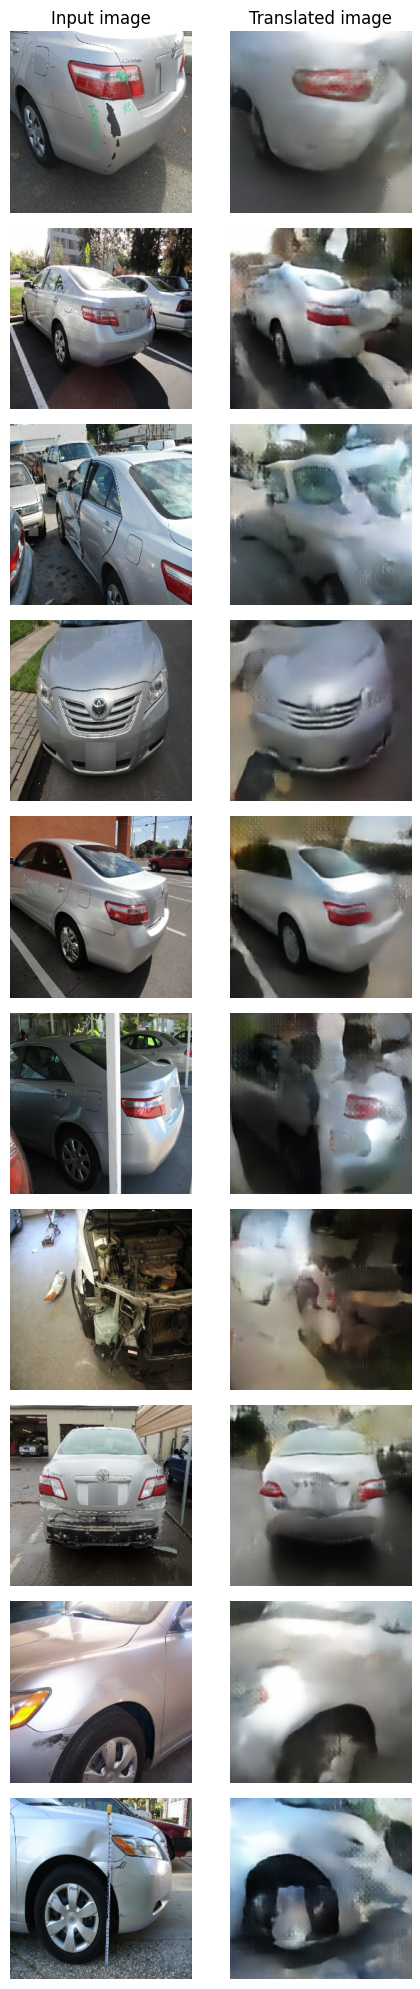

In [40]:
generate_test_images(NetG, val_dataset, 10)

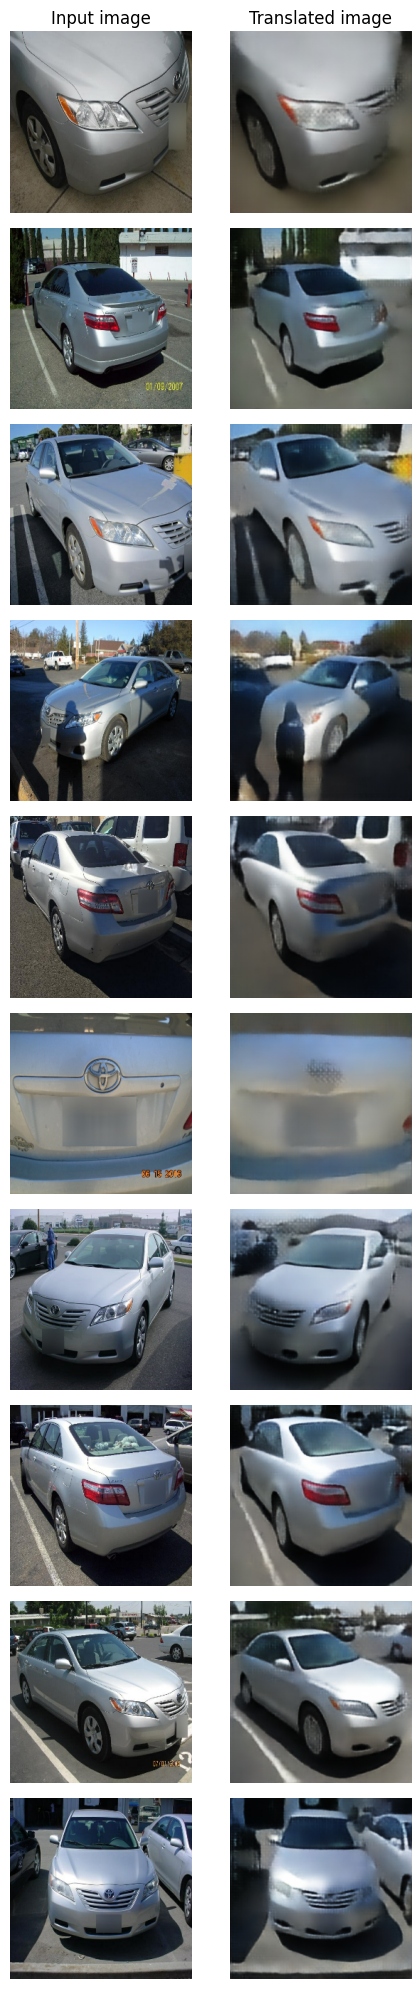

In [41]:
generate_test_images(NetG, train_dataset, 10)